In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

In [2]:
## Read data
df = pd.read_csv("/Users/changlingchen/Downloads/covtype.csv")
print(df.shape)
df.head()

(581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
## Merge categorical variables: Wilderness_Area and Soil_Type
df = df.copy()
ohe_bool = []
enc_cols = ["Wilderness_Area", "Soil_Type"]
for idx, val in enumerate(enc_cols):
  val_df = df.filter(regex=val, axis=1)
  df[val] = val_df.dot(val_df.columns)
  # Convert the constructed columns into int
  df[val] = df[val].astype('str').str.findall(r"(\d+)").str[-1].astype('int')
  df = df.drop(val_df.columns, axis=1)
# Reorder the columns
df = df.iloc[:,df.columns!="Cover_Type"].merge(df["Cover_Type"], left_index=True, right_index=True)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,29,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,29,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,12,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,30,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,29,5


In [4]:
## Summary of relevant variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


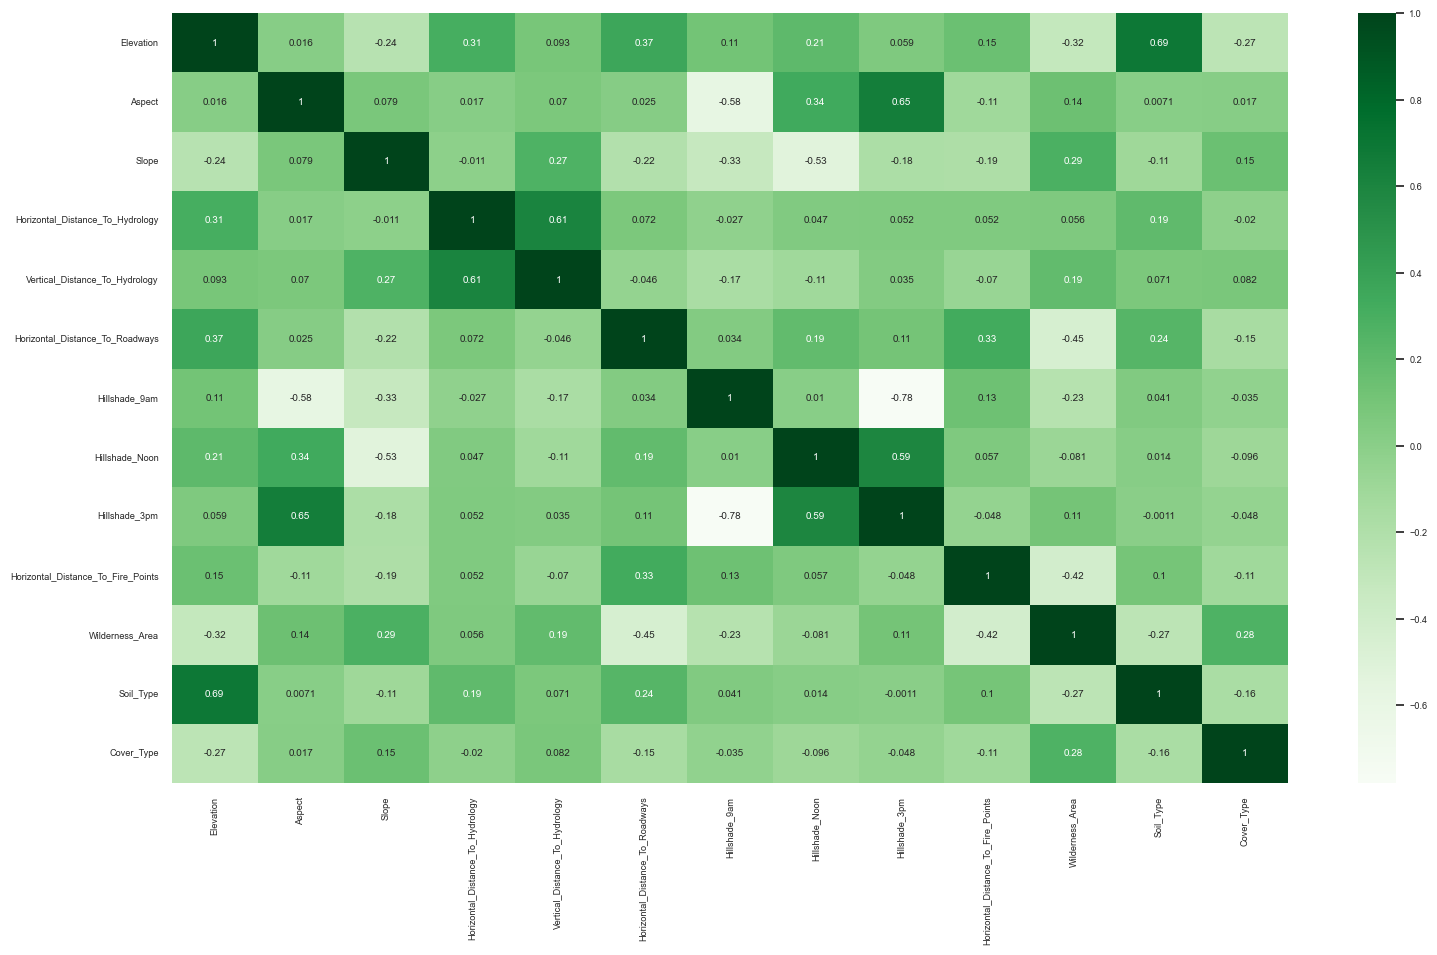

In [5]:
## Correlation plot
import seaborn as sns
cor = df.corr()
plt.figure(figsize=(18,10))
sns.set(font_scale=0.6)
sns.heatmap(cor, annot=True, cmap="Greens")
plt.savefig('/Users/changlingchen/Desktop/stats/stat447/project');

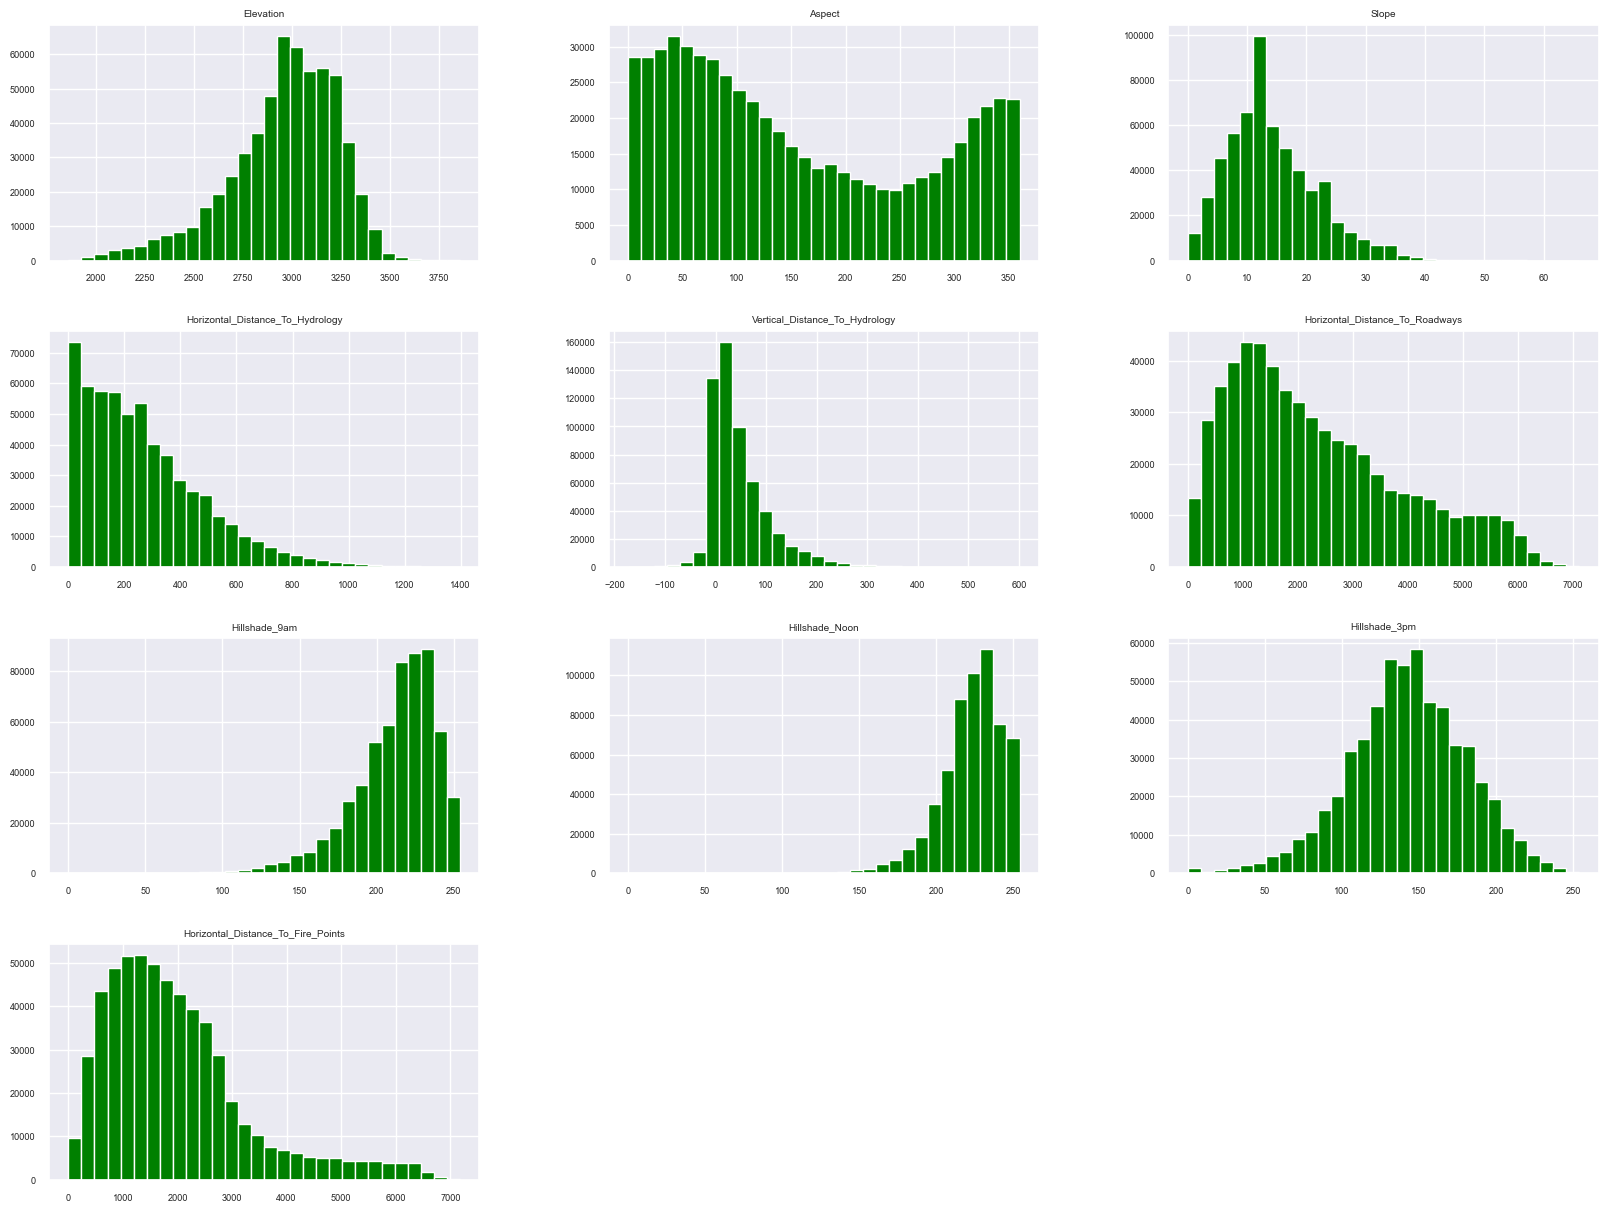

In [7]:
## Histogram of numeric variables
numeric_df = df.drop(columns=["Wilderness_Area","Soil_Type","Cover_Type"])
numeric_df.hist(bins=30, figsize=(20, 15), color = "green")
plt.savefig('/Users/changlingchen/Desktop/stats/stat447/project/all plots/histogram')

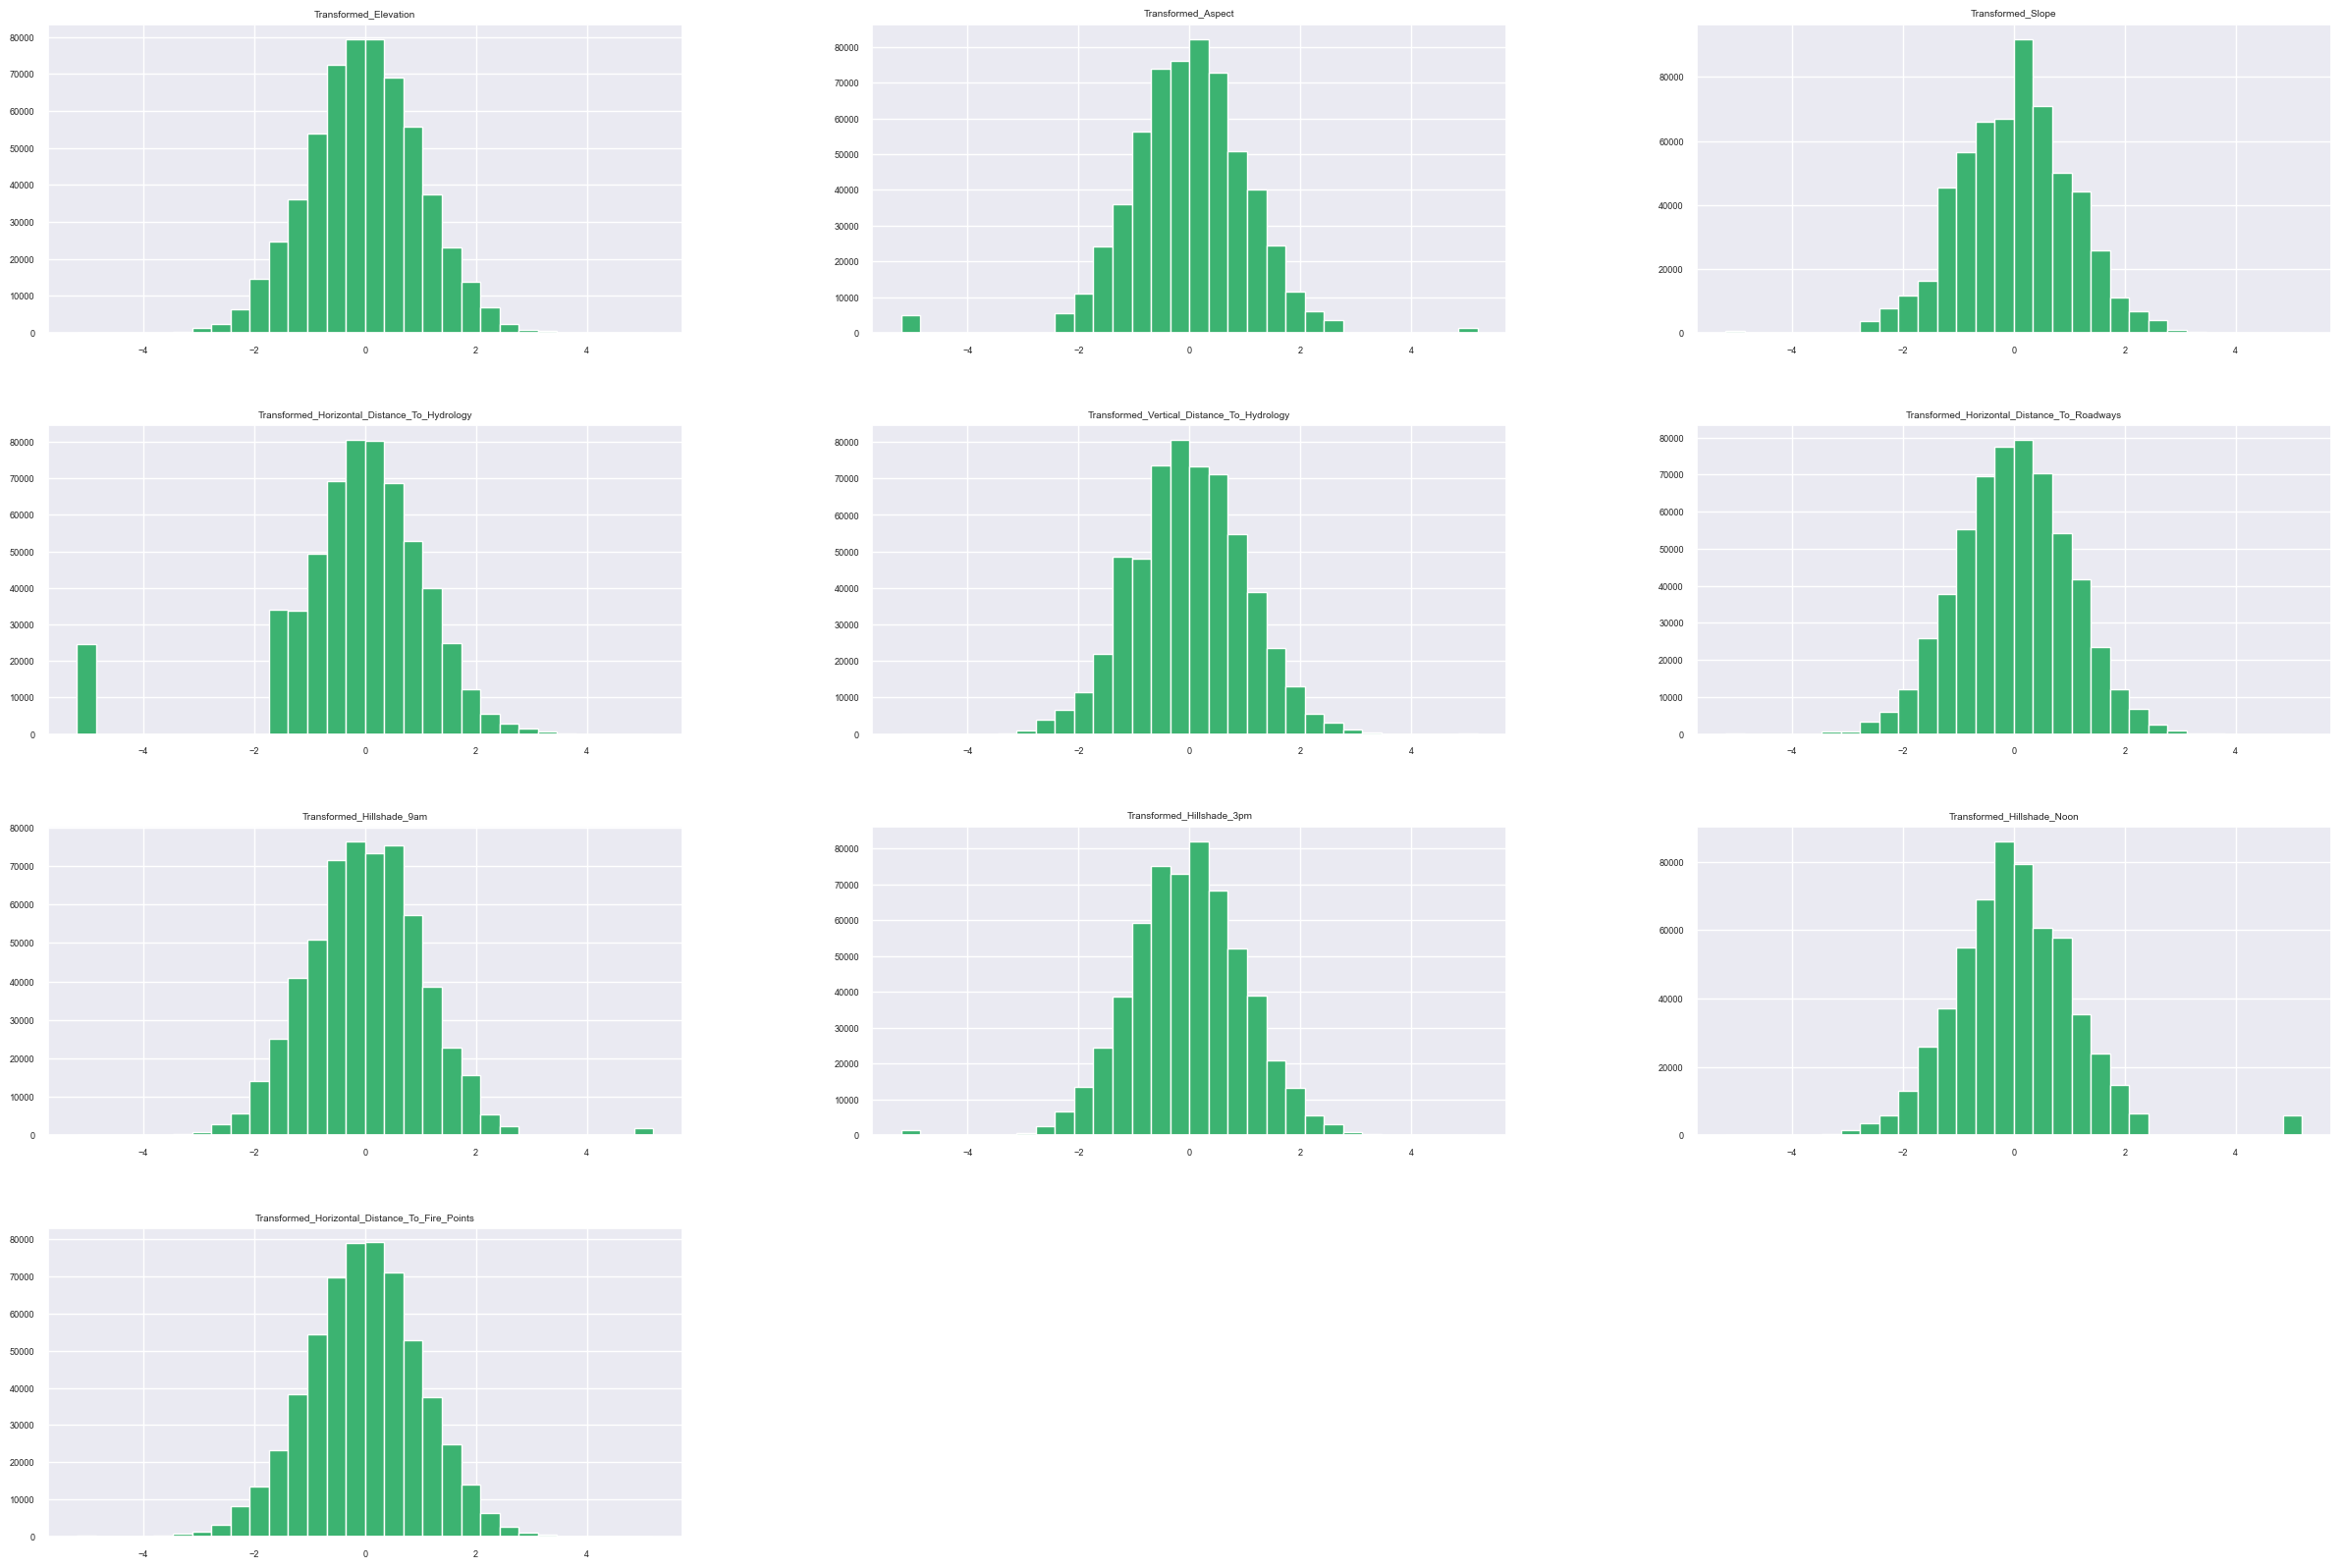

In [47]:
from scipy.stats import boxcox
from scipy.stats import mstats
from sklearn.preprocessing import QuantileTransformer
new_df = numeric_df.copy()
qt = QuantileTransformer(output_distribution='normal')

new_df['Transformed_Elevation'] = qt.fit_transform(new_df[['Elevation']])
new_df['Transformed_Aspect'] = qt.fit_transform(new_df[['Aspect']])
new_df['Transformed_Slope'] = qt.fit_transform(new_df[['Slope']])
new_df['Transformed_Horizontal_Distance_To_Hydrology'] = qt.fit_transform(new_df[['Horizontal_Distance_To_Hydrology']])
new_df['Transformed_Vertical_Distance_To_Hydrology'] = qt.fit_transform(new_df[['Vertical_Distance_To_Hydrology']])
new_df['Transformed_Horizontal_Distance_To_Roadways'] = qt.fit_transform(new_df[['Horizontal_Distance_To_Roadways']])
new_df['Transformed_Hillshade_9am'] = qt.fit_transform(new_df[['Hillshade_9am']])
new_df['Transformed_Hillshade_3pm'] = qt.fit_transform(new_df[['Hillshade_3pm']])
new_df['Transformed_Hillshade_Noon'] = qt.fit_transform(new_df[['Hillshade_Noon']])
new_df['Transformed_Horizontal_Distance_To_Fire_Points'] = qt.fit_transform(new_df[['Horizontal_Distance_To_Fire_Points']])
new_df = new_df.drop(columns=["Elevation","Aspect","Slope","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
                             "Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_3pm","Hillshade_Noon","Horizontal_Distance_To_Fire_Points"])

new_df.hist(bins=30, figsize=(30,20), color = "mediumseagreen")
new_df.head()
plt.savefig('/Users/changlingchen/Desktop/stats/stat447/project/all plots/transformed_histogram')

In [ ]:
numeric_feats = ["Elevation", "Aspect", "Slope",
                 "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
                 "Hillshade_9am","Hillshade_Noon","Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"]  # apply scaling

<AxesSubplot: xlabel='Cover_Type', ylabel='count'>

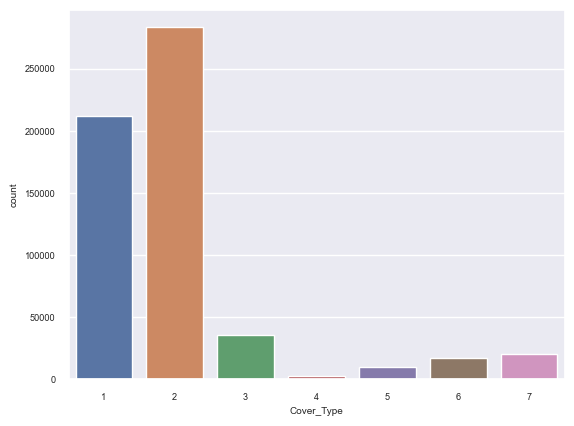

In [7]:
## Check class imbalance
df["Cover_Type"].value_counts(normalize=True)
sns.countplot(x=df["Cover_Type"])

<AxesSubplot: xlabel='Elevation', ylabel='Soil_Type'>

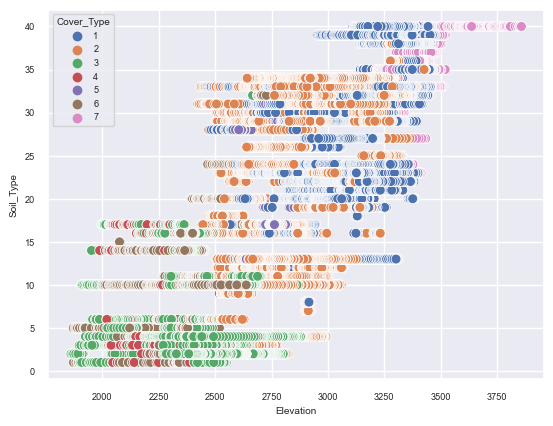

In [10]:
sns.scatterplot(x="Elevation", 
                y="Soil_Type",
                s=50,
                hue="Cover_Type",
                data=df,
                palette="deep")

<AxesSubplot: xlabel='Elevation', ylabel='Horizontal_Distance_To_Roadways'>

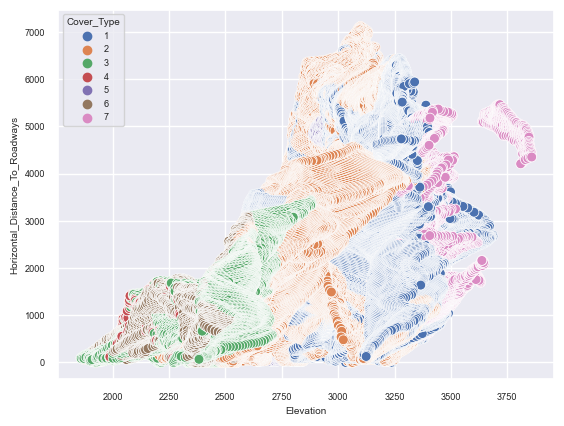

In [9]:
sns.scatterplot(x="Elevation", 
                y="Horizontal_Distance_To_Roadways",
                s=50,
                hue="Cover_Type",
                data=df,
                palette="deep")

<AxesSubplot: xlabel='Horizontal_Distance_To_Hydrology', ylabel='Vertical_Distance_To_Hydrology'>

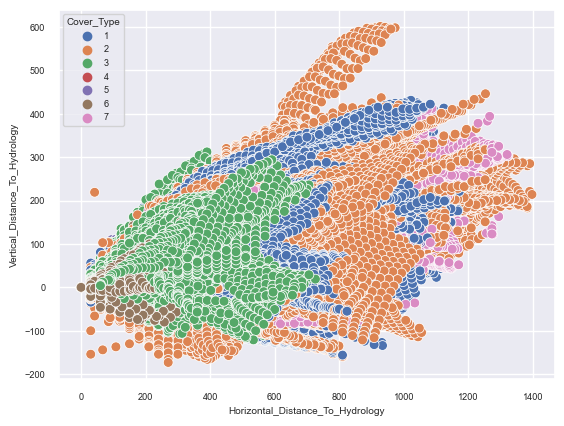

In [14]:
sns.scatterplot(x="Horizontal_Distance_To_Hydrology", 
                y="Vertical_Distance_To_Hydrology",
                s=50,
                hue="Cover_Type",
                data=df,
                palette="deep",
                legend='full')

<AxesSubplot: xlabel='Hillshade_3pm', ylabel='Hillshade_Noon'>

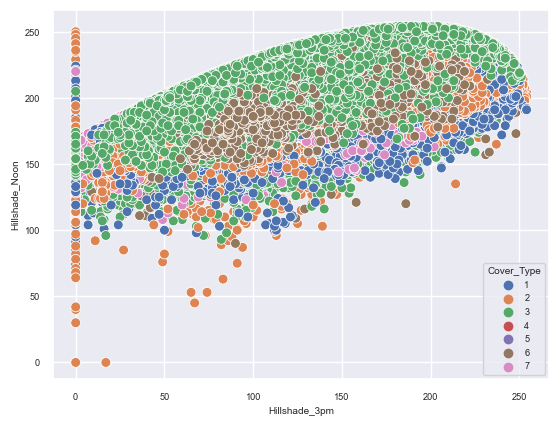

In [15]:
sns.scatterplot(x="Hillshade_3pm", 
                y="Hillshade_Noon",
                s=50,
                hue="Cover_Type",
                data=df,
                palette="deep",
                legend='full')

<AxesSubplot: xlabel='Aspect', ylabel='Hillshade_3pm'>

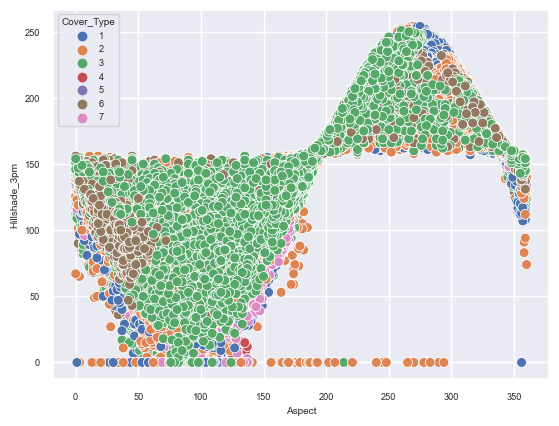

In [13]:
sns.scatterplot(x="Aspect", 
                y="Hillshade_3pm",
                s=50,
                hue="Cover_Type",
                data=df,
                palette="deep",
                legend='full')

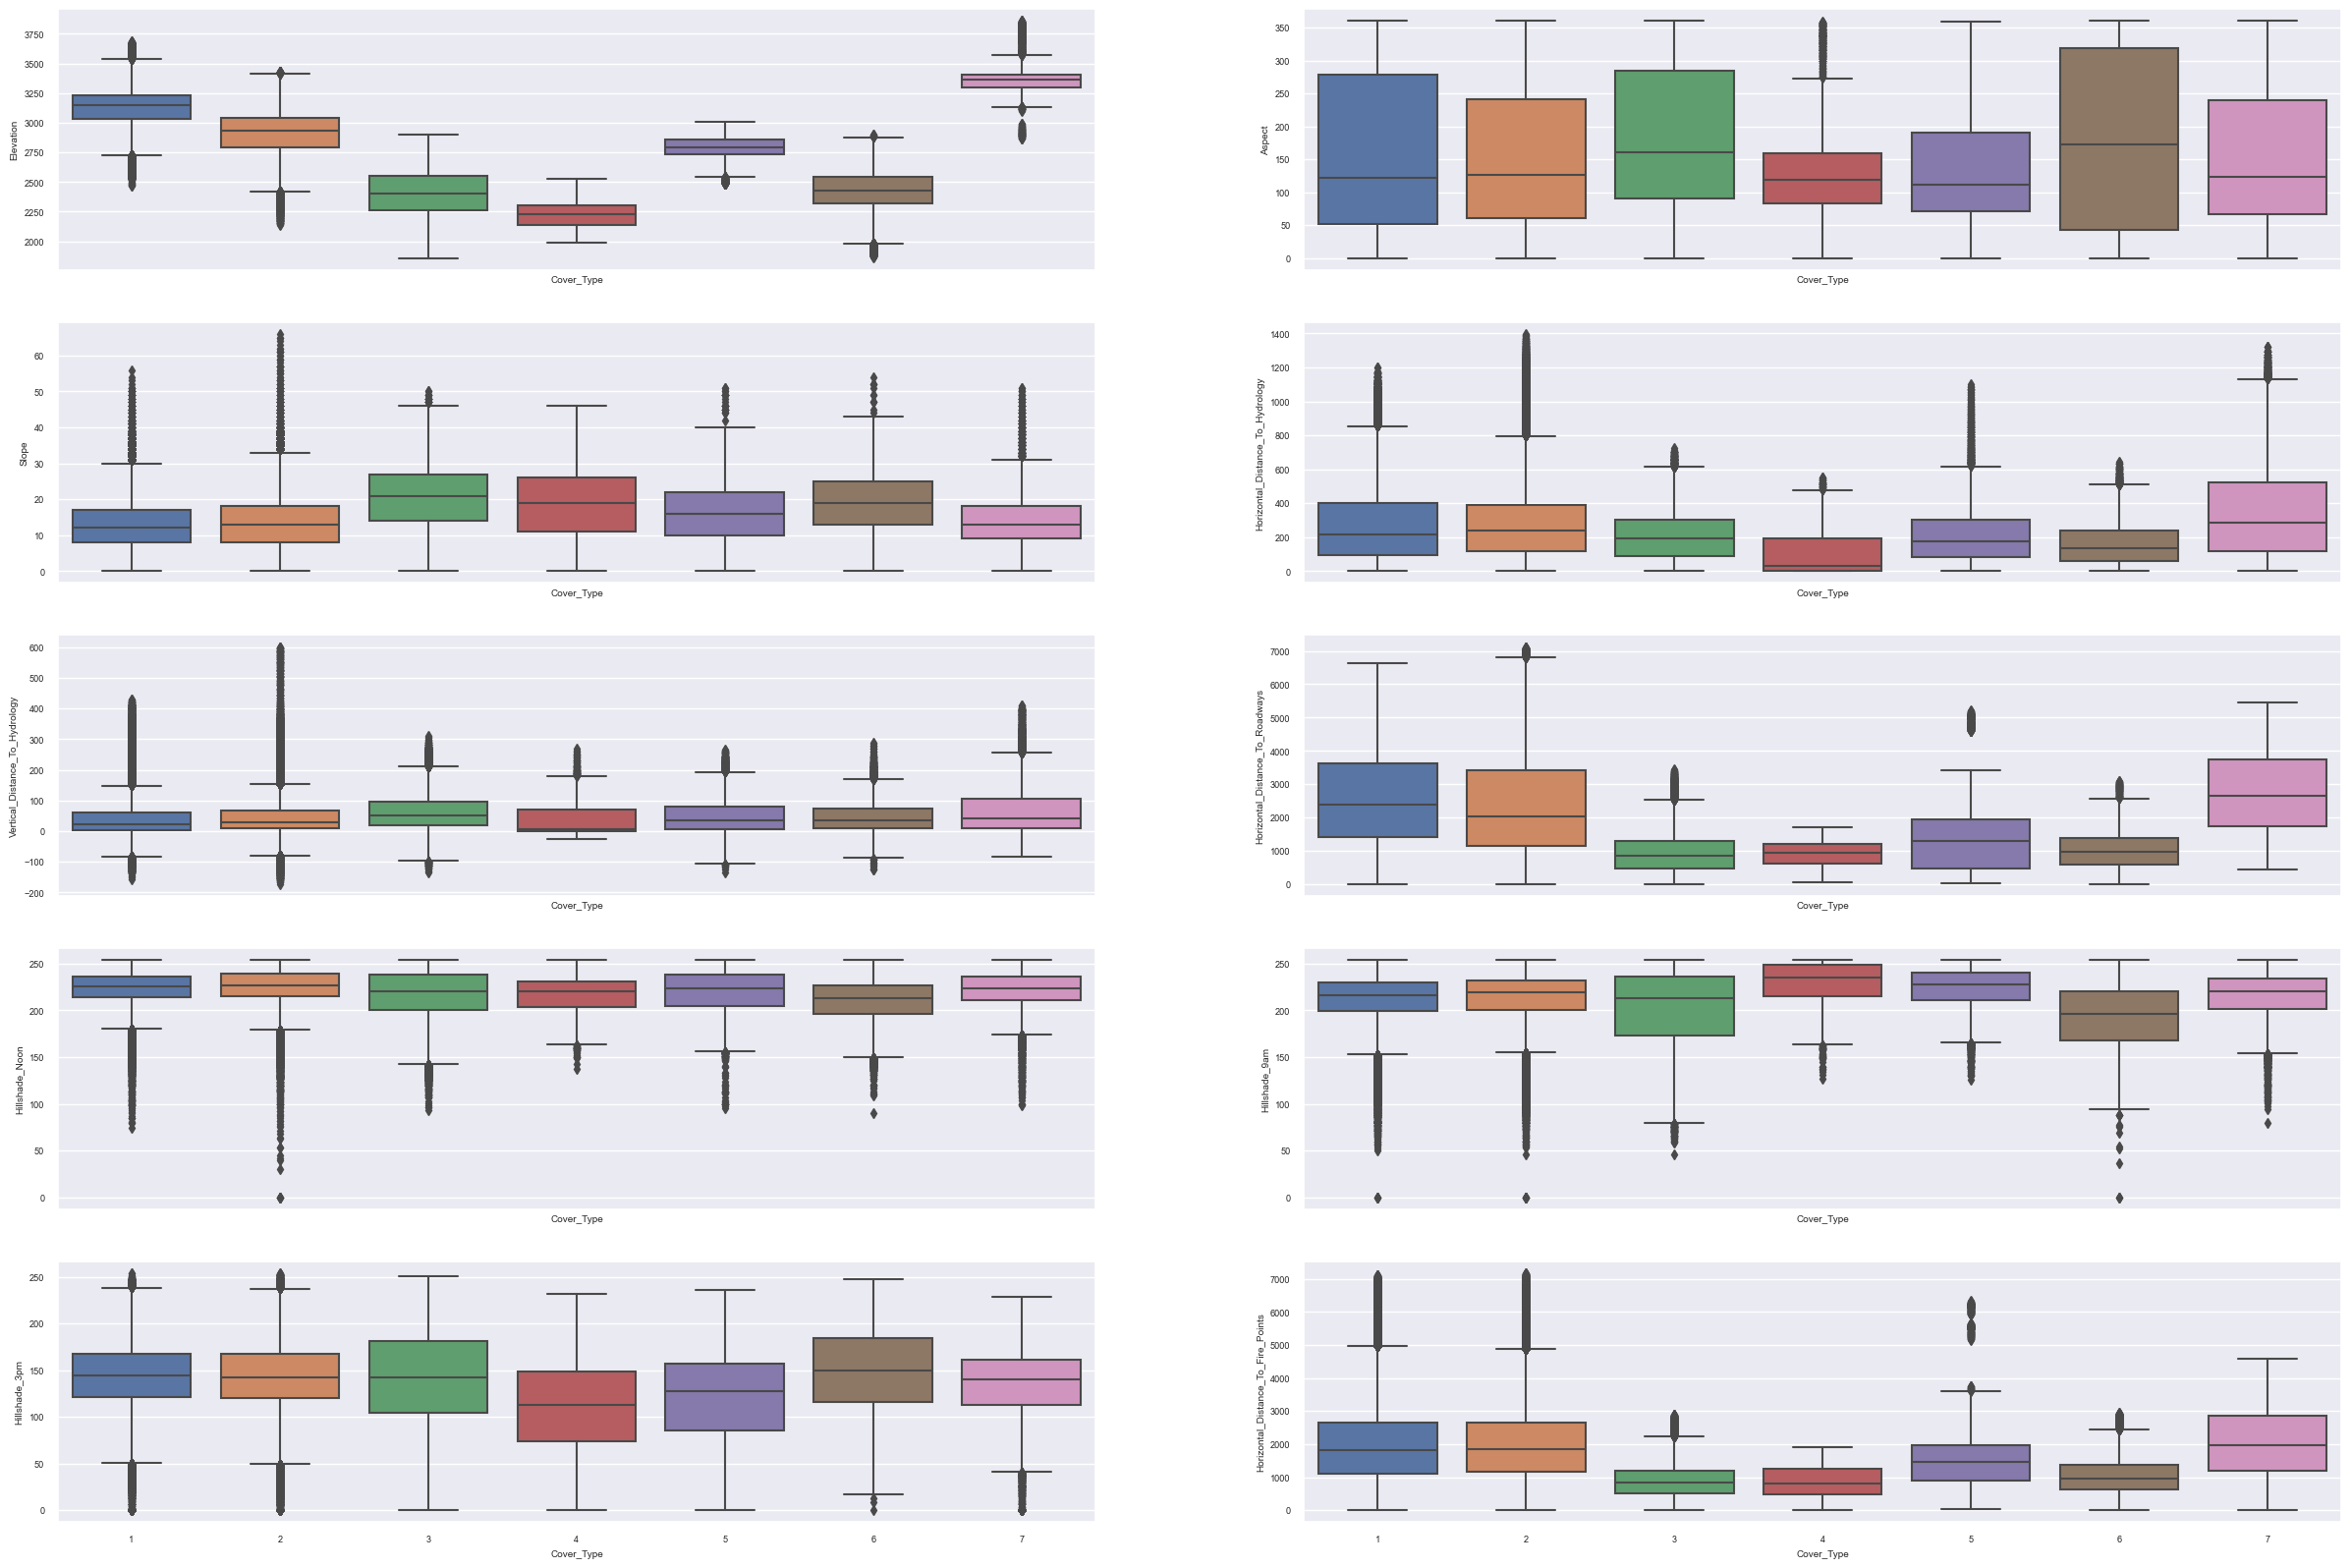

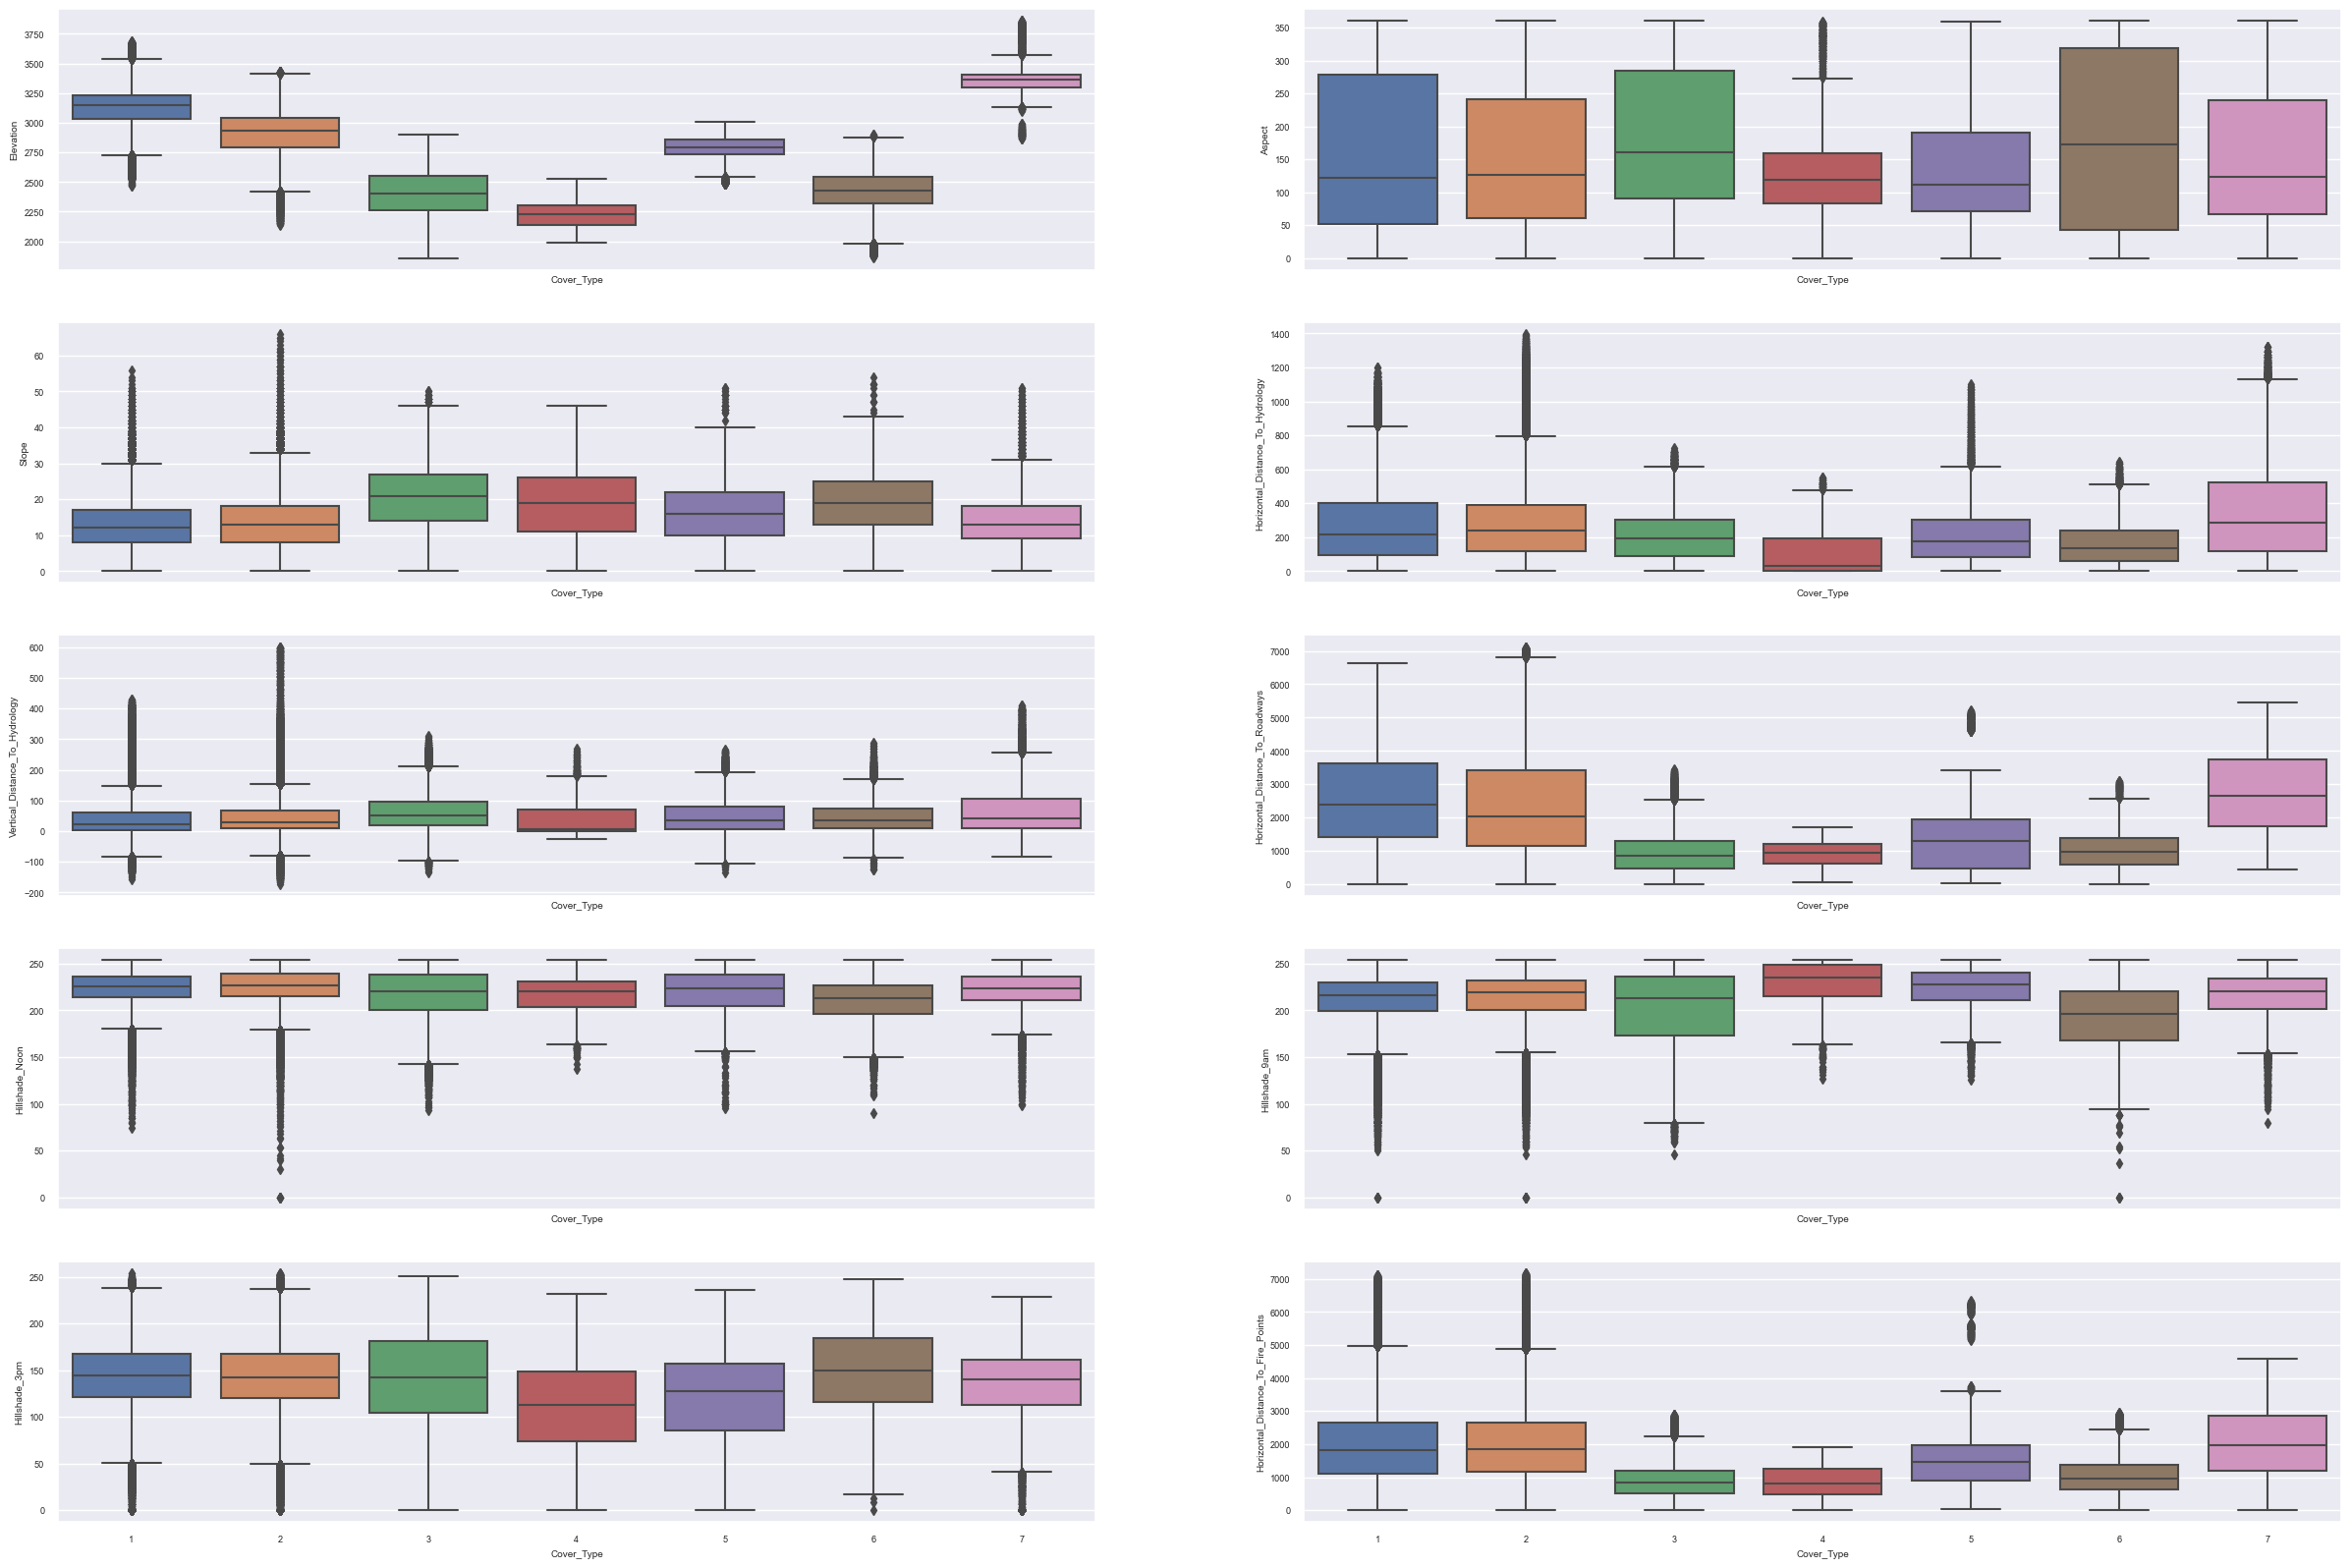

In [16]:
## Side-by-side boxplots
fig, axes = plt.subplots(5,2, sharex=True, figsize=(30,20))
sns.boxplot(data=df, x="Cover_Type", y="Elevation",dodge=False, ax= axes[0,0])
sns.boxplot(data=df, x="Cover_Type", y="Aspect", dodge=False, ax = axes[0,1])
sns.boxplot(data=df, x="Cover_Type", y="Slope",  dodge=False, ax = axes[1,0])
sns.boxplot(data=df, x="Cover_Type", y="Horizontal_Distance_To_Hydrology",dodge=False,ax = axes[1,1])
sns.boxplot(data=df, x="Cover_Type", y="Vertical_Distance_To_Hydrology", dodge=False, ax = axes[2,0])
sns.boxplot(data=df, x="Cover_Type", y="Horizontal_Distance_To_Roadways", dodge=False, ax = axes[2,1])
sns.boxplot(data=df, x="Cover_Type", y="Hillshade_Noon", dodge=False,ax = axes[3,0])
sns.boxplot(data=df, x="Cover_Type", y="Hillshade_9am", dodge=False,ax = axes[3,1])
sns.boxplot(data=df, x="Cover_Type", y="Hillshade_3pm", dodge=False, ax = axes[4,0])
sns.boxplot(data=df, x="Cover_Type", y="Horizontal_Distance_To_Fire_Points", dodge=False, ax = axes[4,1])
fig

In [ ]:
sns.pairplot(df, hue="Cover_Type")